<a href="https://colab.research.google.com/github/gcfcmu/Projects/blob/main/02_620_HW4_Programming_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__02-620 HW4 Programming - Image classification using Pytorch__

In this last homework, we will learn basic deep learning. Deep learning is a fast moving research area. There is ongoing research on why it works so well, but so far the theory of deep learning is still building in progress. Due to this nature of the field, hands-on experience is the most important in deep learning.

We will use Pytorch, one of the popular deep learning frameworks. If you are unfamiliar with the Pytorch, please watch the recitation video and look at the recitation material, where we covered basic understanding of Pytorch.

Because our course is an introductory machine learning course, we covered broad topics in machine learning and thus we can't go very deep into deep learning. So we will go through only the basics of deep learning. Throughout the homework, we hope you'll get familiar with deep learning and Pytorch framework.

Referenced 16-720 and 16-824, great courses in CMU

In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 MB 4.0 MB/s eta 0:00:0000:0100:01


In [ ]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.9 MB/s eta 0:00:0000:0100:01


In [2]:
#Feel free to import any required library you need.
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize

import matplotlib.pyplot as plt
import os
import pandas as pd

import numpy as np 

torch.manual_seed(0) #For reproducibility

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# mount drive to be able to save training states

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#__General Task description__

In this assignment, our task is to build a workflow of classifying the objects using deep learning models. The dataset we are interested in is CIFAR10(https://www.cs.toronto.edu/~kriz/cifar.html). This dataset includes 60,000 32x32 color images in 10 clases. It has 50,000 training samples and 10,000 test samples. You can download the dataset using torchvision.datasets.CIFAR10()

__TODOs__
1. Change path to your desired path!!!
2. Once you download your data, you can change it to False

In [5]:
your_path='/content' # path ./ outside of Google Collab
download=True
#download = False


#transform data for augmentation 

train_transform = Compose([
    Resize((256)), 
    ToTensor(),
    RandomRotation(degrees=(0, 180)), 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transform = Compose([
    Resize((256)), 
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])


trainset = torchvision.datasets.CIFAR10(root=your_path, train=True,download=download, transform = train_transform)
testset = torchvision.datasets.CIFAR10(root=your_path, train=False, download=download, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(trainset)



print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


#__Task 1 Build your own DataLoader(10 Points)__

As we covered in the recitation, Pytorch uses the DataLoader class to bring datapoints to the neural network. You can do any preprocessing in this step.

Take a look at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

There can be possibility that you don't have enough dataset. In this case, we can populate the dataset using data augmentation. For example, in Computer Vision, one way to augment your data is adding rotated images.

BE CAREFUL: In Pytorch, one of the argument in the DataLoader is indicating train or test. This is very important argument because you do data augmentation with training samples, but not with test samples. You should consider this when you implement DataLoader.

Tip:
1. It is very important to understand what is your data and how they are organized. Observe how folder and files strutured in the downloaded CIFAR10. See the annotation files, open the images, try to see if there is any pattern in file name, etc.
2. For data augmentation, feel free to use methods in torchvision.transforms

__TODOs__
1. Form your own DataLoader
2. In the __getitem__, add your own data augmentation.
3. You should have an variable that controls size of the image. For this assignment, use size of 256: that is, image should be (256, 256, 3). Please be mind that when you load this image to the Tensor, it might be changed to (3, 256, 256)

In [ ]:
#This is copied from the Pytorch document. Feel free to utilize it, or build entirely new one
class CustomImageDataset(torchvision.datasets.CIFAR10):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Now you should be able to bring and use your Dataloader

In [6]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#__Task 2 Build Neural Network(5 Points)__

If you look at some of the deep learning papers, they provide their model architecture, which is how they organized their neural network. Through this task, you should be able to rebuild the neural network given model architecture.
The model we are interested in is AlexNet(https://arxiv.org/abs/1404.5997). For simplicity, we are going to implement a slightly simplified version.


This is the model you should rebuild:

AlexNet(

  (features): Sequential(
  
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace))
  
  (classifier): Sequential(
  
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1)))
)


__TODO: Implement the model architcture__

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        
        
        super(AlexNet, self).__init__()

        self.features=nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), #j
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True))
            

        self.classifier=nn.Sequential(
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
            
        )
        
        #We will give this initialization for you
        for neuron in self.features:
            if isinstance(neuron,nn.Conv2d):
                nn.init.xavier_uniform_(neuron.weight)
        
        
    def forward(self, x):
        
        x = (self.features(x))
        x = self.classifier(x)
        return x

Using cuda device


#__Task 3 Build deep learning pipeline(20 Points)__

You have Dataset, DataLoader, and your model. It's time to make a pipeline with ingredients. In the recitation, we covered that before we build a training loop, we need to define loss and optimizer. Due to the limited time, we will provide you with loss and optimizer. Use the given parameters.

In [ ]:
#initialize model
model = AlexNet().to(device)

#Do not change this cell
num_iter=20
loss_fn=nn.BCELoss()
optimizer=torch.torch.optim.SGD(model.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
for X, y in trainloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


Now, build a deep learning pipeline. 

__TODOs: Finish the pipeline. Bring your DataLoader and the model here. Organize the train loop and test loop, and then train and test your model. At the end of the pipeline, your pipeline should be able to provide graphs of training accuracy, test accuracy and training loss, and report final test accuracy. If you implement it well, your test accuracy should be around 65%.__

__IMPORTANT: After you get predictions from your model, please add below codes before you put the prediction into loss function. Remember below lines should be added in both training loop and test loop!__

        (assume you used pred=model(X))
        '''
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        '''
        Then loss(pred,y) and goes on

In [ ]:
def train(trainloader, model, loss_fn, optimizer):
    size = len(trainloader.dataset)
    model.train()

    trainingLoss = 0 
    correct = 0
    
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        
        y = torch.nn.functional.one_hot(y, num_classes= 10)
        
        y = y.to(device).float()

        # Compute prediction error
        pred = model(X)
        
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        
        loss = loss_fn(pred, y)
        
        trainingLoss = trainingLoss + loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    trainingAccuracy = correct / size 
    averageTrainingLoss = trainingLoss / 64

    print("training accuracy:", trainingAccuracy, "average training loss:", averageTrainingLoss)

    return (trainingAccuracy, averageTrainingLoss)
  

In [ ]:
def test(testloader, model, loss_fn):
    size = len(testloader.dataset)
    num_batches = len(testloader)
    
    model.eval()
    test_loss, correct = 0, 0
    
    
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            
            y = torch.nn.functional.one_hot(y, num_classes= 10)
        
            y = y.to(device).float()
            
            
            pred = model(X)
            
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,10))#(-1,10)
            pred=F.sigmoid(pred)
            
            
            test_loss += loss_fn(pred, y).item()
            
            
            
            
            
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    testAccuracy = correct / size 
    correct /= size

    averageTestLoss = test_loss / num_batches 
    

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return testAccuracy, averageTestLoss
    

In [ ]:
#trainingAcc, trainingLoss = train(trainloader, model, loss_fn, optimizer) # for bug fixing

loss: 0.299561  [   64/50000]
loss: 0.293596  [ 6464/50000]
loss: 0.290935  [12864/50000]
loss: 0.310052  [19264/50000]
loss: 0.297880  [25664/50000]
loss: 0.282279  [32064/50000]
loss: 0.300687  [38464/50000]
loss: 0.286146  [44864/50000]
0.24396 3.5833086068741977


In [ ]:
vals = torch.load("/content/drive/MyDrive/values.pt")


trAc = vals['training accuracy']
trLoss = vals['training loss']
tsAc = vals['test accuracy']
tsLoss = vals['averageTestLoss']


#model = AlexNet().to(device)
#model.load_state_dict(torch.load("/content/drive/MyDrive/mo.pt")[20])

#Load the above if a previous state already exists. Else:
"""
trAc = []
trLoss = []
tsAc = []
tsLoss = []
"""

for i in tsAc:
  tsAc = tsAc * len(testloader.dataset)



In [ ]:
#DONT RUN THIS CELL

epochs = 10
checkpoint = 0#len(trAc) # do zero if starting from scratch

for t in range(checkpoint, checkpoint + epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainingAcc, trainingLoss = train(trainloader, model, loss_fn, optimizer)
    testAccuracy, averageTestloss = test(testloader, model, loss_fn)
    scheduler.step(averageTestloss)

    trAc.append(trainingAcc)
    trLoss.append(trainingLoss)
    tsAc.append(testAccuracy)
    tsLoss.append(averageTestloss)

    """
    #Save desired values into Google Drive for later use
    torch.save({"training accuracy" : trAc, 
                "training loss" : trLoss,
                "test accuracy" : tsAc,
                "averageTestLoss" : tsLoss}, "/content/drive/MyDrive/values.pt")
    torch.save({len(trAc) : model.state_dict()}, "/content/drive/MyDrive/mo.pt")
"""


print("Done!")

Epoch 11
-------------------------------
loss: 0.233218  [   64/50000]
loss: 0.237396  [ 6464/50000]
loss: 0.229542  [12864/50000]
loss: 0.216172  [19264/50000]
loss: 0.256912  [25664/50000]
loss: 0.221658  [32064/50000]
loss: 0.229157  [38464/50000]
loss: 0.246687  [44864/50000]
0.43986 2.949883625144139
Test Error: 
 Accuracy: 33.4%, Avg loss: 0.275193 

Epoch 12
-------------------------------
loss: 0.262656  [   64/50000]
loss: 0.249825  [ 6464/50000]
loss: 0.228663  [12864/50000]
loss: 0.235467  [19264/50000]
loss: 0.239070  [25664/50000]
loss: 0.254704  [32064/50000]
loss: 0.235232  [38464/50000]
loss: 0.257754  [44864/50000]
0.45654 2.8972827312536538
Test Error: 
 Accuracy: 28.4%, Avg loss: 0.311050 

Epoch 13
-------------------------------
loss: 0.268606  [   64/50000]
loss: 0.238164  [ 6464/50000]
loss: 0.244784  [12864/50000]
loss: 0.198877  [19264/50000]
loss: 0.231153  [25664/50000]
loss: 0.217310  [32064/50000]
loss: 0.229158  [38464/50000]
loss: 0.226776  [44864/50000]


In [ ]:

# testing for loading stuff


"""
print("len values")
print(len(torch.load("/content/drive/MyDrive/values.pt")))
print()

print("values")
print(torch.load("/content/drive/MyDrive/values.pt"))
print()

print("len mo")
print(len(torch.load("/content/drive/MyDrive/mo.pt")))
print()

print("mo keys")
print(torch.load("/content/drive/MyDrive/mo.pt").keys())
print()
"""

'\nprint("len values")\nprint(len(torch.load("/content/drive/MyDrive/values.pt")))\nprint()\n\nprint("values")\nprint(torch.load("/content/drive/MyDrive/values.pt"))\nprint()\n\nprint("len mo")\nprint(len(torch.load("/content/drive/MyDrive/mo.pt")))\nprint()\n\nprint("mo keys")\nprint(torch.load("/content/drive/MyDrive/mo.pt").keys())\nprint()\n'

[0.23636, 0.26586, 0.29008, 0.31012, 0.32966, 0.34594, 0.36796, 0.3833, 0.40654, 0.42042, 0.43986, 0.45654, 0.46802, 0.48274, 0.50226, 0.51686, 0.53258, 0.54722, 0.55894, 0.5724]
[0.29494494317895004, 0.28789055275032893, 0.28148182409117595, 0.275831817551647, 0.2705431474977747, 0.26568296220144044, 0.2599826759999365, 0.25555189918069277, 0.2507101051375994, 0.24608842291109398, 0.24142270077905997, 0.23711776828674405, 0.23247137498062895, 0.2279352205412467, 0.2231360404654537, 0.2181024993281535, 0.21315916400888693, 0.20843617349405727, 0.2042708809456557, 0.19952304125823023]
[0.2204, 0.2333, 0.262, 0.2854, 0.2705, 0.3084, 0.2959, 0.3233, 0.3415, 0.3276, 0.33379999999999993, 0.2844, 0.37660000000000005, 0.4141, 0.4012, 0.30960000000000004, 0.3342, 0.4028, 0.3716, 0.4076]
[0.29938978659119575, 0.2958855923194035, 0.288162650576063, 0.2835414421026874, 0.28935086119706466, 0.27762736123838244, 0.2805513119811465, 0.2767079841748924, 0.27135810047198256, 0.280774702122257, 0.27519

Text(0, 0.5, 'Accuracy')

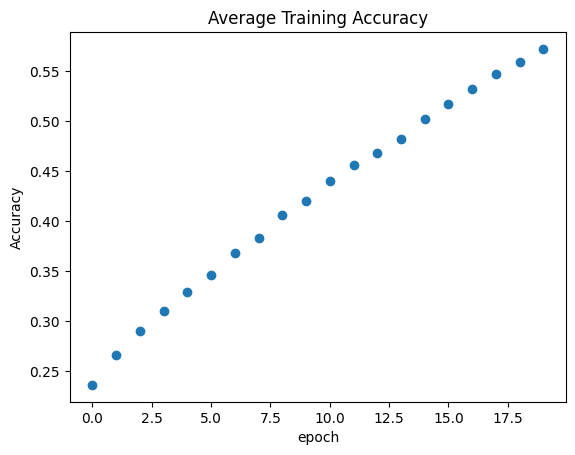

In [ ]:

#Load in the values again...
#But this time do some processing on the values because the train and test functions
#are messed up 

vals = torch.load("/content/drive/MyDrive/values.pt")

trAc = vals['training accuracy']
trLoss = vals['training loss']
tsAc = vals['test accuracy']
tsLoss = vals['averageTestLoss']

for i in range(len(trLoss)):
  trLoss[i] = (trLoss[i] * 64) / len(trainloader)

for i in range(len(tsAc)):
  tsAc[i] = tsAc[i]

for i in range(len(trLoss)):
  tsLoss[i] = (tsLoss[i] * len(testloader))

print(trAc)
print(trLoss)
print(tsAc)
print(tsLoss)


plt.scatter([i for i in range(20)], trAc)
plt.title("Average Training Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")




Text(0, 0.5, 'Loss')

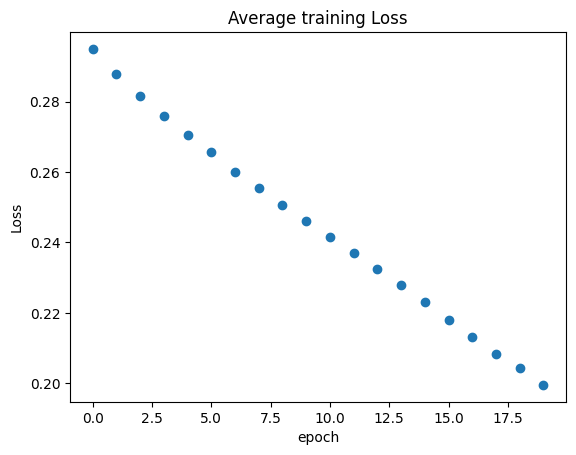

In [ ]:
plt.scatter([i for i in range(20)], trLoss)
plt.title("Average training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

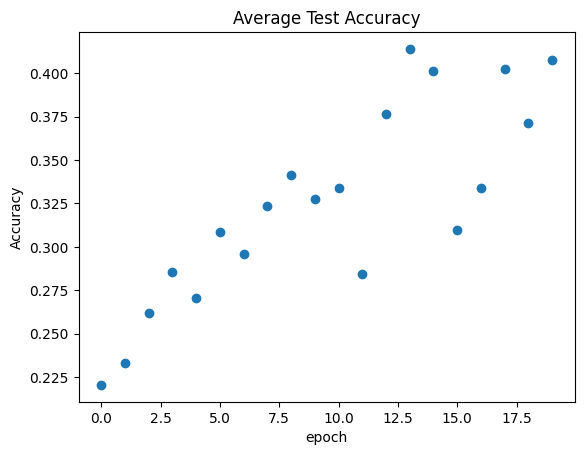

In [4]:
plt.scatter([i for i in range(20)], tsAc)
plt.title("Average Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

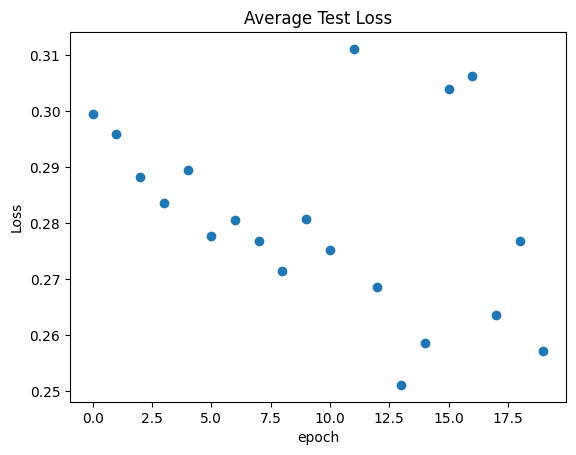

In [ ]:
plt.scatter([i for i in range(20)], tsLoss)
plt.title("Average Test Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

#__Task 4 Weight transfer(Transfer learning)(5 Points)__

There can be two possible scenarios when you are given neural network architcture: One is build everything entirely from the scratch, as you implemented above, and the other is using the pretrained model. The former is preferred when there is no pretrained model or you are training with novel(or unpopular) dataset. The latter is generally more preferred, especially if you are working in computer vision or natural langauge processing related area, because most of the pretrained neural network works very well and their pretrained dataset is very large scale such that starting from raw training might consume great amount of time. For the latter case, it's just one line of code:

In [ ]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True) #DO NOT USE THIS CODE IN THIS ASSIGNMENT

In this task, we will slightly tweak: You will not use the above code to bring a pretrained model. Instead, you will transfer the weights of the pretrained model to the model you built above. Knowing this will help you later when you want to build your own model but basic flow comes from previous existing models.

One thing you should know, and should remember for your future is that Pytorch stores trained weights as a dictionary data structure, the key and value, and their name of the key has a pattern such that you can easily load your desired key and corresponding weights.


If your implementation is correct, your final accuracy should be around 80%


__TODOs: Implement below weight transfer function. Then train and test your pretrained model.Provide graphs of training accuracy, test accuracy and training loss. Report final accuracy__

In [ ]:
from torchvision._internally_replaced_utils import load_state_dict_from_url # This is the hint!

def Load_Alexnet_Weight_Transferred(pretrained=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model_urls = {
            'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    }    
    
    model2 = AlexNet().to(device)

    
    loaded = load_state_dict_from_url(model_urls["alexnet"])

    

    keys = list(loaded.keys())

    if pretrained:

        for i in keys:
            
            if i not in model2.state_dict() or model2.state_dict()[i].shape != loaded[i].shape:

              loaded.pop(i)
            
        
        model2.load_state_dict(loaded, strict = False)

        return model2
    return model2


model_pretrained = Load_Alexnet_Weight_Transferred(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 79.0MB/s]


In [ ]:
num_iter=20
loss_fn=nn.BCELoss()
optimizer2=torch.torch.optim.SGD(model_pretrained.parameters(),lr=0.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min')

In [ ]:
#Lets reinitialize this stuff

trAc = []
trLoss = []
tsAc = []
tsLoss = []

In [ ]:


epochs = 20
checkpoint = 0#len(trAc)

for t in range(checkpoint, checkpoint + epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainingAcc, trainingLoss = train(trainloader, model_pretrained, loss_fn, optimizer2)
    testAccuracy, averageTestloss = test(testloader, model_pretrained, loss_fn)
    scheduler2.step(averageTestloss)

    trAc.append(trainingAcc)
    trLoss.append(trainingLoss * 64 / len(trainloader)) # actually do the correct values this time
    tsAc.append(testAccuracy * 100)
    tsLoss.append(averageTestloss)

""" # more saving stuff 
    torch.save({"training accuracy" : trAc, 
                "training loss" : trLoss,
                "test accuracy" : tsAc,
                "averageTestLoss" : tsLoss}, "/content/drive/MyDrive/weighted.pt")
    torch.save({len(trAc) : model_pretrained.state_dict()}, "/content/drive/MyDrive/modifiedWt.pt")
""""


print("Done!")

Epoch 1
-------------------------------
loss: 0.263618  [   64/50000]
loss: 0.271635  [ 6464/50000]
loss: 0.257235  [12864/50000]
loss: 0.292640  [19264/50000]
loss: 0.243570  [25664/50000]
loss: 0.232593  [32064/50000]
loss: 0.233067  [38464/50000]
loss: 0.233551  [44864/50000]
training accuracy: 0.40498 average training loss: 3.0633236025460064
Test Error: 
 Accuracy: 36.3%, Avg loss: 0.268316 

Epoch 2
-------------------------------
loss: 0.253251  [   64/50000]
loss: 0.237293  [ 6464/50000]
loss: 0.218414  [12864/50000]
loss: 0.220143  [19264/50000]
loss: 0.244246  [25664/50000]
loss: 0.223240  [32064/50000]
loss: 0.199465  [38464/50000]
loss: 0.216851  [44864/50000]
training accuracy: 0.49548 average training loss: 2.736734872451052
Test Error: 
 Accuracy: 35.5%, Avg loss: 0.285725 

Epoch 3
-------------------------------
loss: 0.271679  [   64/50000]
loss: 0.191683  [ 6464/50000]
loss: 0.201103  [12864/50000]
loss: 0.195273  [19264/50000]
loss: 0.214831  [25664/50000]
loss: 0.1

In [ ]:
#torch.save({"epoch 20" : optimizer2}, "/content/drive/MyDrive/optimizer.pt") # save the optimizer

In [ ]:
 # load more 
print("values")
a = torch.load("/content/drive/MyDrive/valbrc.pt")
print()

print(a["test accuracy"])


tsAc = a["test accuracy"]
trAc = a["training accuracy"]
tsLoss = a["averageTestLoss"]
trLoss = a["training loss"]
"""
for i in range(len(tsAc)):
  tsAc[i] = tsAc[i]*100 


print(len(tsAc))"""

values

[0.3772446054021428, 0.2011971228811428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428, 0.3772446054021428]


'\nfor i in range(len(tsAc)):\n tsAc[i] = tsAc[i]*100 \n\n\nprint(len(tsAc))'

Text(0, 0.5, 'Accuracy')

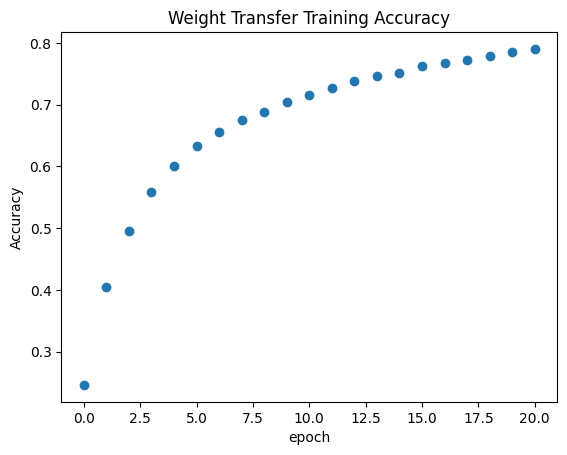

In [ ]:
plt.scatter([i for i in range(21)], trAc)
plt.title("Weight Transfer Training Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
# Final training accuracy is 79.02%

Text(0, 0.5, 'Loss')

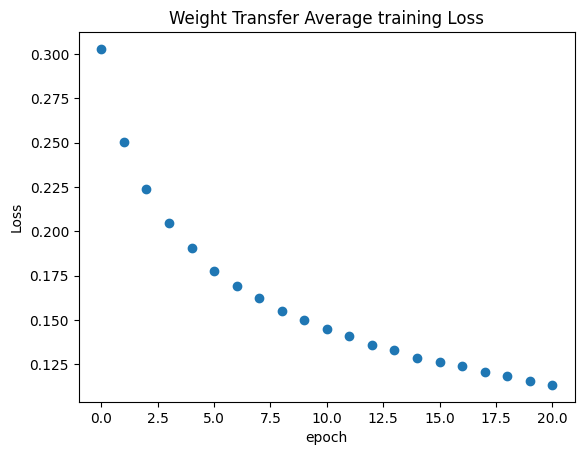

In [ ]:
plt.scatter([i for i in range(21)], trLoss)
plt.title("Weight Transfer Average training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

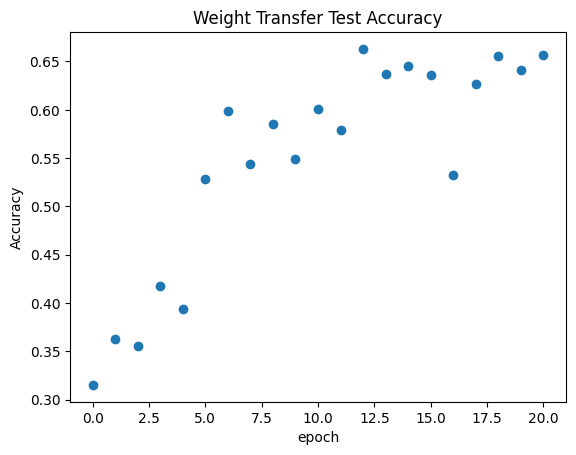

In [ ]:
plt.scatter([i for i in range(21)], tsAc)
plt.title("Weight Transfer Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Final test accuracy is 65.7%

Text(0, 0.5, 'Loss')

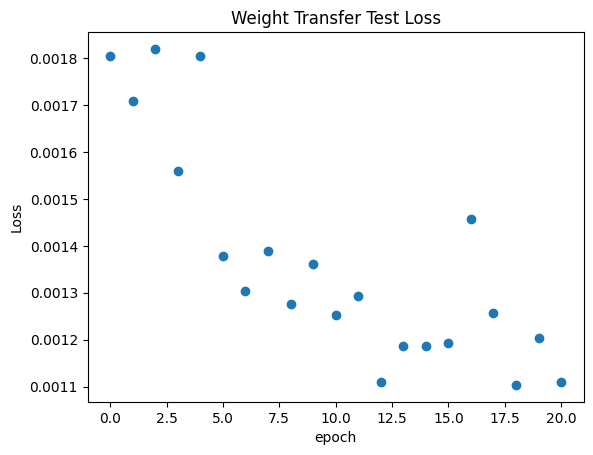

In [ ]:
plt.scatter([i for i in range(21)], tsLoss)
plt.title("Weight Transfer Test Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

#__Task 5 Evaluate your model(10 Points)__

You have a full loop of both train and test. Let's see how good your model is. In the lecture, we learned precision, recall. In addition to these metrics, one way to visualize our model performance is to show a heatmap of classification result. You need to build a (# classes)x(# classes) matrix. Then, for each sample in the test set with a true label ith class, we can get jth class through your model. Then we add a value to matrix[i][j], then we normalize the matrix. By doing so, we can visually show our performance. Remember that in CIFAR10, we have 10 classes. 

__TODOs__
1. Visualize the heatmap, and report which class showed most accurate, and which 'task' showed most mistakes, i.e, predicted j when the true label is i.
2. Provide 3 cases of failed prediction with most mistakes 'task'. So you should show a total of 6 images here. Briefly write why you think the model can't predict well.

In [ ]:
def EvaluateModel(testloader, model, hmap, failedPredictions):
    size = len(testloader.dataset)
    num_batches = len(testloader)
    
    model.eval()
    test_loss, correct = 0, 0
    totalFailedPredictions = list()

    batch = 0 
    
    with torch.no_grad():
        for X, y in testloader:

            
            X, y = X.to(device), y.to(device)
            
            y = torch.nn.functional.one_hot(y, num_classes= 10)
        
            y = y.to(device).float()
            
            
            pred = model(X)

            
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,10))#(-1,10)
            pred=F.sigmoid(pred)     
            
            


            for i in range(len(pred.argmax(1))):
              predicted = pred.argmax(1)[i].item()
              actual = y.argmax(1)[i].item()
              hmap[actual][predicted] += 1

              
              
              if failedPredictions[1] == predicted and failedPredictions[0] == actual:
                totalFailedPredictions.append(batch * 64 + i)

            batch += 1
            


        
        for i in range(len(hmap)):
          hmap[:,i] = hmap[:,i] / np.sum(hmap[:,i])
        

    return hmap, totalFailedPredictions

    

In [ ]:
import numpy as np 

hmap = np.zeros((10, 10))

hmap, totalFailedPredictions = EvaluateModel(testloader, model_pretrained, hmap, [8, 0]) 
# [8, 0] is the highest error prediction 
# can initialize with [0, 0] and then rerun function with the highest error class 






['bear', 'bear', 'bear', 'bear', 'bear', 'bear', 'bear', 'bear', 'bear', 'bear']


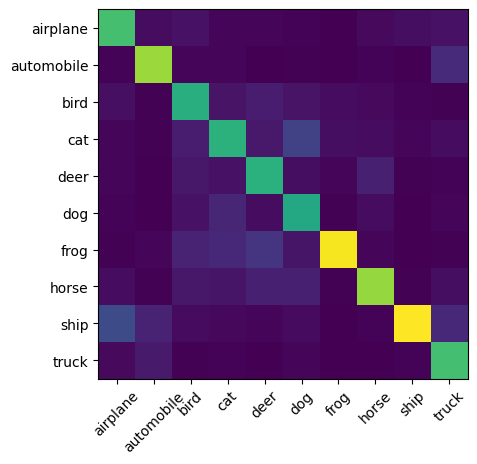

In [ ]:
ax = plt.gca()

ax.imshow(hmap)

ordered = ["" for i in range(10)]

for key in testset.class_to_idx.keys():
  classnum = testset.class_to_idx[key]
  ordered[classnum] = key


print(["bear" for j in range(10)])

ax.set_xticks([float(i) for i in range(10)], ordered, rotation = 45)
ax.set_yticks([float(i) for i in range(10)], ordered)

In [ ]:
numCorrects = [hmap[i][i] for i in range(10)]

mx = max(numCorrects)

for i in range(len(numCorrects)):
  if mx == numCorrects[i]:
    index = i 


print("The highest accuracy class has accuracy", max(numCorrects), "when predicting", ordered[index])

highestError = 0

indexi, indexj = 0, 0

for i in range(len(hmap)):
  for j in range(len(hmap[0])):
    if i != j and hmap[i][j] > highestError:
      highestError = hmap[i][j]
      indexi = i
      indexj = j

print("the highest error class is has error", highestError, "true label of", ordered[indexi], "with predicted label", ordered[indexj])

#print(indexi, indexj)

# predicting airplane when the true label is a ship has the most mistakes
# although predicting ship has the highest true positive rate...
# this may mean the network loves thinking everything is a ship 




The highest accuracy class has accuracy 0.9101123595505618 when predicting ship
the highest error class is has error 0.21017514595496248 true label of ship with predicted label airplane


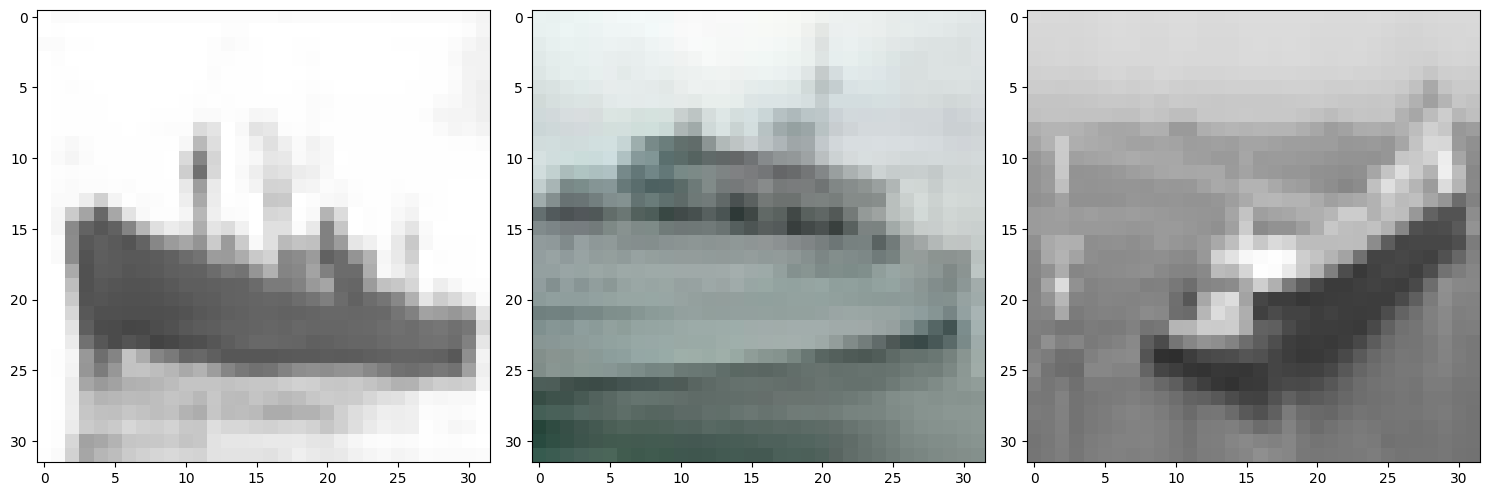

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))


ax[0].imshow(testset.data[totalFailedPredictions[1]])
ax[1].imshow(testset.data[totalFailedPredictions[2]])
ax[2].imshow(testset.data[totalFailedPredictions[3]])


fig.tight_layout()

# the below images are predicted to be airplanes, but the true label is ship. Perhaps the main reason for the model failing to predict these is the image
# quality. Although, it may be able to improve prediction if more epochs are ran. 
# for this assignment, I ran it for 21 epochs. So more epochs would increase the accuracy.



Write analysis here

#__Task 6 Create your own model(10 Points OR 10 Points + 10 Bonus Points)__

You have two options, and this task is open ended. 

Make your own model. Name the model class with your name(e.g. YoungJeNet). Briefly describe how you organized your model architecture and pipeline, and why you proposed such architecture (feel free to take inspiration from common architectures, and please reference any tutorials/guides that you use). Feel free to use your designed DataLoader and feel free to weight shift from any different model. Also feel free to use your training and test loop.
With your defined model, run your pipeline on a new dataset and provide graphs of training accuracy and training loss, and report final accuracy.

Do NOT just bring pretrained model: Like model=some_kind_of_pretrained_model(pretrain=True)

For your new dataset, choose one of the following options:
1. (10 Points) One of the following standard datasets: CIFAR10, PASCAL VOC, CALTECH256, or ImageNet2012.

2. (10 Points + 10 Bonus Points) Find a dataset of your interest in biology. We are giving bonus points here because you need to describe further about your dataset and may need to work more with Dataloader.

Please be mind that if you choose 2, this should not be part of your project.

Your score will be determined based on 1. Description of dataset 2. Clearly stated idea and correctly implemented the idea. 3. Not too low accuracy. Please be aware that accuracy is not the only criterion here.

In [ ]:
#dataset found at https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
#I split into test and train manually
#contains breast cancer images of three classes benign, malignant and normal
#the dataset used is in my Google Drive: https://drive.google.com/drive/folders/1wlxtuYSDFCgW7UK-a8kiOS31BmBdHini?usp=share_link 


transformation = Compose([
    Resize((400, 400)), 
    ToTensor(), 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainroot = "/content/drive/MyDrive/BreastCancer/train"
testroot = "/content/drive/MyDrive/BreastCancer/test"

print(os.getcwd())

train_dataset = torchvision.datasets.ImageFolder(
    root=trainroot,
    transform=transformation
)

test_dataset = torchvision.datasets.ImageFolder(
    root=testroot,
    transform=transformation
)


print(train_dataset)
print(test_dataset)




/content
Dataset ImageFolder
    Number of datapoints: 778
    Root location: /content/drive/MyDrive/BreastCancer/train
    StandardTransform
Transform: Compose(
               Resize(size=(400, 400), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 141
    Root location: /content/drive/MyDrive/BreastCancer/test
    StandardTransform
Transform: Compose(
               Resize(size=(400, 400), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
print(train_dataset)
print(len(train_dataset))
print(len(train_dataset[0]))
print(len(train_dataset[0][0]))
print(len(train_dataset[0][0][0]))
print(len(train_dataset[0][0][0][0]))


Dataset ImageFolder
    Number of datapoints: 1397
    Root location: /content/drive/MyDrive/BreastCancer/train
    StandardTransform
Transform: ToTensor()
1397
2
3
471
562


In [ ]:
tsloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True, num_workers=2)
trloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True, num_workers=2)

In [ ]:


class CoolNet(nn.Module):

    def __init__(self, num_classes=10):
        
        
        super(CoolNet, self).__init__()
        
        
        self.features=nn.Sequential(
            

           
            
            nn.Conv2d(3, 256, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), #j
            nn.ReLU(inplace=True),

            #compression layer
            nn.Conv2d(256, 10, kernel_size=(7,7), stride=(2,2), padding=(2,2)), 
            nn.ReLU(inplace=True),

            nn.Conv2d(10, 400, kernel_size=(3,3), stride=(1,1), padding=(2,2)),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(400, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True))
            
            
        
        
        #TODO: Define Classifiers
        self.classifier=nn.Sequential(
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
            
        )
        
        #We will give this initialization for you
        for neuron in self.features:
            if isinstance(neuron,nn.Conv2d):
                nn.init.xavier_uniform_(neuron.weight)
        
        
    def forward(self, x):
        #TODO: Define forward pass
        x = (self.features(x))
        x = self.classifier(x)
        return x

In [ ]:
modelb = CoolNet().to(device)
loss_fn=nn.BCELoss()
optimizerb=torch.torch.optim.SGD(modelb.parameters(),lr=0.1)
schedulerb = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerb, 'min')

In [ ]:
def TrainCustom(trainloader, model, loss_fn, optimizer):
    size = len(trainloader.dataset)
    model.train()

    trainingLoss = 0 
    correct = 0
    
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        
        
        y = torch.nn.functional.one_hot(y, num_classes= 3)
        
        y = y.to(device).float()

        # Compute prediction error
        pred = model(X)
        
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,3))#(-1,10)
        pred=F.sigmoid(pred)
        
        loss = loss_fn(pred, y)
        
        trainingLoss = trainingLoss + loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    trainingAccuracy = correct / size 
    averageTrainingLoss = trainingLoss / len(trloader)

    print("training accuracy:", trainingAccuracy, "average training loss:", averageTrainingLoss)

    return (trainingAccuracy, averageTrainingLoss)

def TestCustom(testloader, model, loss_fn):
    size = len(testloader.dataset)
    num_batches = len(testloader)
    
    model.eval()
    test_loss, correct = 0, 0
    
    
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            
            y = torch.nn.functional.one_hot(y, num_classes= 3)
        
            y = y.to(device).float()
            
            
            pred = model(X)
            
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,3))#(-1,10)
            pred=F.sigmoid(pred)
            
            
            test_loss += loss_fn(pred, y).item()
            
            
            
            
            
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    testAccuracy = correct / size 
    correct /= size

    averageTestLoss = test_loss / num_batches 
    
    
    print(correct)
    print(testAccuracy)

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return testAccuracy, averageTestLoss
    

In [ ]:
TestCustom(tsloader, modelb, loss_fn)

0.5319148936170213
0.5319148936170213
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.599878 



(0.5319148936170213, 0.199959311220381)

In [ ]:
#TrainCustom(trloader, modelb, loss_fn, optimizerb)

0
loss: 0.662974  [   64/  778]
1
2
3
4
5
6
7
8
9
10
11
12
training accuracy: 0.5141388174807198 average training loss: 0.13311559241265059


(0.5141388174807198, 0.13311559241265059)

In [ ]:
trAc = []
tsAc = []
trLoss = []
tsLoss = []

In [ ]:
epochs = 10
checkpoint = 0#len(trAc)

for t in range(checkpoint, checkpoint + epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainingAcc, trainingLoss = TrainCustom(trloader, modelb, loss_fn, optimizerb)
    testAccuracy, averageTestloss = TestCustom(tsloader, modelb, loss_fn)
    schedulerb.step(averageTestloss)

    trAc.append(trainingAcc)
    trLoss.append(trainingLoss)
    tsAc.append(testAccuracy)
    tsLoss.append(averageTestloss)

# more saving stuff 
    torch.save({"training accuracy" : trAc, 
                "training loss" : trLoss,
                "test accuracy" : tsAc,
                "averageTestLoss" : tsLoss}, "/content/drive/MyDrive/valbrc.pt")
    torch.save({"epoch" + str(len(trAc)) : modelb.state_dict()}, "/content/drive/MyDrive/modelbrc.pt")
    torch.save({"epoch" + str(len(trAc)) : optimizerb}, "/content/drive/MyDrive/optbrc.pt") # save the optimizer



print("Done!")

Epoch 1
-------------------------------
loss: 0.696451  [   64/  778]
training accuracy: 0.3264781491002571 average training loss: 0.6833361478952261
Test Error: 
 Accuracy: 28.4%, Avg loss: 0.672958 

Epoch 2
-------------------------------
loss: 0.665847  [   64/  778]
training accuracy: 0.487146529562982 average training loss: 0.6600561829713675
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.652402 

Epoch 3
-------------------------------
loss: 0.651247  [   64/  778]
training accuracy: 0.5141388174807198 average training loss: 0.6427980340444125
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.631962 

Epoch 4
-------------------------------
loss: 0.637597  [   64/  778]
training accuracy: 0.5141388174807198 average training loss: 0.6267161323474004
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.622202 

Epoch 5
-------------------------------
loss: 0.619417  [   64/  778]
training accuracy: 0.5141388174807198 average training loss: 0.615835428237915
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.6

In [ ]:
for i in a.keys():
  print(i, len(a[i]), a[i])



training accuracy 10 [0.3264781491002571, 0.487146529562982, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198, 0.5141388174807198]
training loss 10 [0.6833361478952261, 0.6600561829713675, 0.6427980340444125, 0.6267161323474004, 0.615835428237915, 0.6065473694067735, 0.5974437731962937, 0.5972463901226337, 0.5912140928781949, 0.5890514392119187]
test accuracy 10 [0.28368794326241137, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213, 0.5319148936170213]
averageTestLoss 10 [0.22431922621197173, 0.2174673080444336, 0.21065396070480347, 0.20740080542034575, 0.2117816872066922, 0.1999661260181003, 0.19763116704093087, 0.19791064659754434, 0.19561558961868286, 0.1964708036846585]


Text(0, 0.5, 'Accuracy')

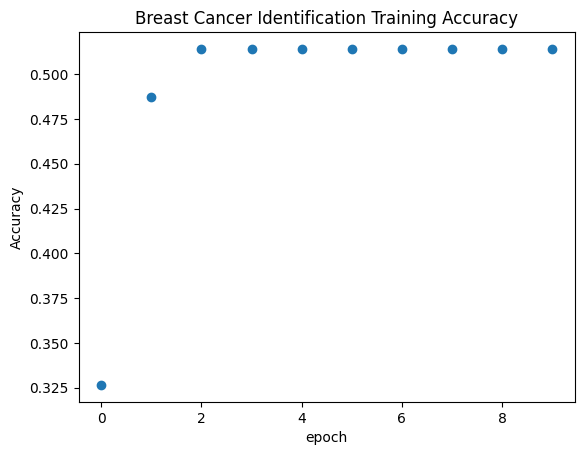

In [9]:
plt.scatter([i for i in range(10)], trAc)
plt.title("Breast Cancer Identification Training Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

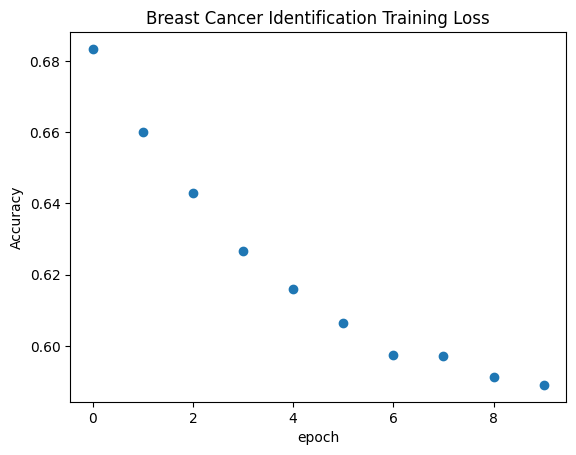

In [10]:
plt.scatter([i for i in range(10)], trLoss)
plt.title("Breast Cancer Identification Training Loss")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

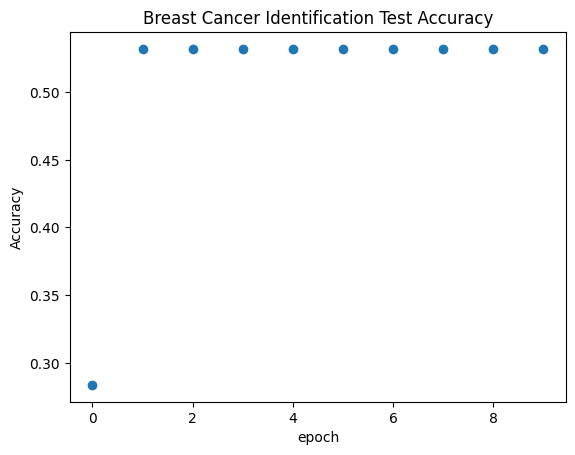

In [11]:
plt.scatter([i for i in range(10)], tsAc)
plt.title("Breast Cancer Identification Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

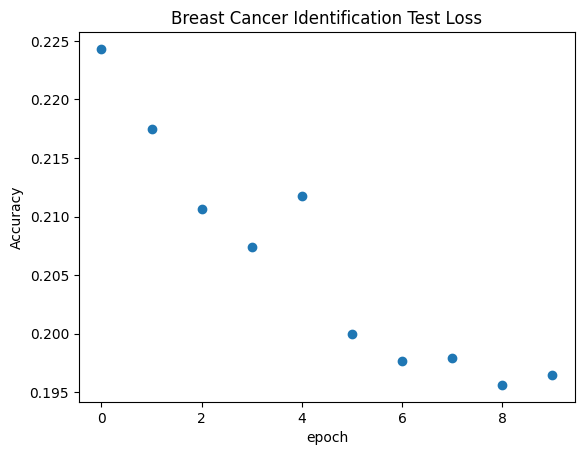

In [12]:
plt.scatter([i for i in range(10)], tsLoss)
plt.title("Breast Cancer Identification Test Loss")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

In [ ]:
# The accuracy is fairly good considering 3 classes. However, it reaches a plateau too quickly. This may be a limit of the model architecture I used
# I tried to implement some sort of compression layers like was shown in lecture. But it may also be due to the dataset itself.
# The data only had 700 samples (I did not use the masks in the original dataset). So there may be some issues there.
# However, the loss kept going down, indicating that it was at least learning even though the accuracy did not change. 

(Option) For your career, we encourage you to upload your work on Github. Github is a repository for programmers. This repo can be useful to your future career, especially if you aim to work in a computational job: provide your Github link to recruiter/research POI. By doing so, you can show your recruiter/research POI that you have fundamental ability to work with deep learning and being able to code Pytorch.

Congratulations! Now you understand the basic flow of deep learning workflow. CMU provides a variety of deep learning courses, so we recommend taking any of them if you are interested or strengthen your knowledge and skills in deep learning. If you want to learn general deep learning, consider 11-685 Introduction to Deep learning. Be careful that this course is very hectic. LTI and RI offer domain specific deep learning courses(such as Natural Language Processing, Visual Learning and Recognition). If you want to know deep learning theory, consider 10-707. Please be aware that what we've covered in this assignment is very basic: this is going to be assignment 0 for other deep learning courses. However, we believe that this assignment will work as a immigration assignment to deep learning.